In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def get_keypoint(left_img, right_img):
    l_img = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
    r_img = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)
    
    sift = cv.SIFT_create()
    key_points1, descriptor1 = sift.detectAndCompute(l_img, None)
    key_points2, descriptor2 = sift.detectAndCompute(r_img, None)
    
    return key_points1, descriptor1, key_points2, descriptor2


def match_keypoints(descriptor1, descriptor2):
    # match SIFT descriptors
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptor1, descriptor2, k=2)

    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good_matches.append(m)    
    
    return good_matches

def set_axes_equal(ax):
    # set 3D plot axes to equal scale so spheres look like spheres
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim3d([mid_x - max_range, mid_x + max_range])
    ax.set_ylim3d([mid_y - max_range, mid_y + max_range])
    ax.set_zlim3d([mid_z - max_range, mid_z + max_range])

In [3]:
img1 = cv.imread('data/left.png')
img2 = cv.imread('data/right.png')    

if img1 is None or img2 is None:
    raise FileNotFoundError("One or both images failed to read.")

scale = 0.3
img1 = cv.resize(img1, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
img2 = cv.resize(img2, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)

# camera intrinsic matrix
f, cx, cy = 48.5, 48.5, 48.5
K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])

# extract SIFT keypoints
key_points1, descriptor1, key_points2, descriptor2 = get_keypoint(img1, img2)

# match SIFT descriptors
good_matches = match_keypoints(descriptor1, descriptor2)

# calculate fundamental matrix
pts1 = np.float32([key_points1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([key_points2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

F, inlier_mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC, 2, 0.999, maxIters=10000)
print(f'* F = {F}')
print(f'* number of inliers = {sum(inlier_mask.ravel())}')

# compute relative camera pose 
E = K.T @ F @ K # essential matrix
positive_num, R, t, positive_mask = cv.recoverPose(E, pts1, pts2, K, mask=inlier_mask)
print(f'* R = {R}')
print(f'* t = {t}')
print(f'* position of image #2 = {-R.T @ t}') 
print(f'* number of positive-depth inliers = {sum(positive_mask.ravel())}')

# reconstruct 3D points (triangulation)
P0 = K @ np.eye(3, 4, dtype=np.float32)
Rt = np.hstack((R, t))
P1 = K @ Rt
pts1_inlier = pts1[inlier_mask.ravel() == 1]
pts2_inlier = pts2[inlier_mask.ravel() == 1]
X = cv.triangulatePoints(P0, P1, pts1_inlier, pts2_inlier)
X /= X[3]
X = X.T



* F = [[ 1.69248464e-06 -2.98739919e-06 -6.97748280e-03]
 [ 5.43437955e-05  4.11082556e-05 -2.15139015e-01]
 [ 2.94427880e-03  1.97082848e-01  1.00000000e+00]]
* number of inliers = 47
* R = [[ 0.99992133  0.00478357  0.01159492]
 [-0.00492511  0.99991333  0.01220989]
 [-0.01153551 -0.01226604  0.99985823]]
* t = [[-0.99944118]
 [ 0.0334097 ]
 [-0.00106277]]
* position of image #2 = [[ 0.99951484]
 [-0.02863894]
 [ 0.01224313]]
* number of positive-depth inliers = 43


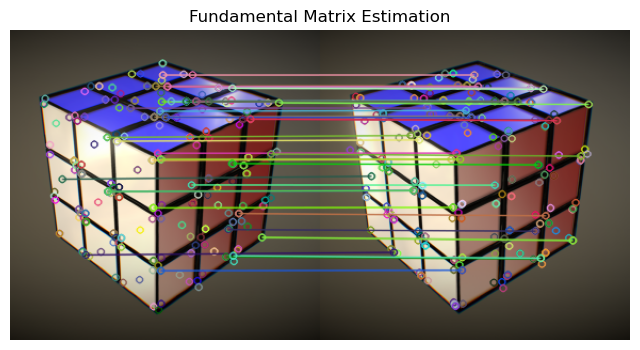

In [4]:
# show matched inlier features
img_matched = cv.drawMatches(img1, key_points1, img2, key_points2, good_matches, None, None, None,
                            matchesMask=inlier_mask.ravel().tolist()) # Remove `matchesMask` if you want to show all putative matches   
plt.figure(figsize=(8,6))
plt.imshow(cv.cvtColor(img_matched, cv.COLOR_BGR2RGB))
plt.title('Fundamental Matrix Estimation')
plt.axis('off')
plt.show() 

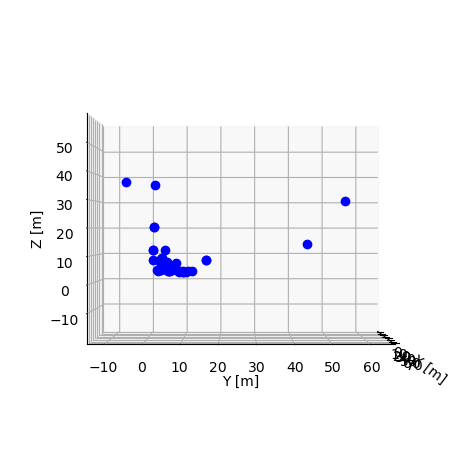

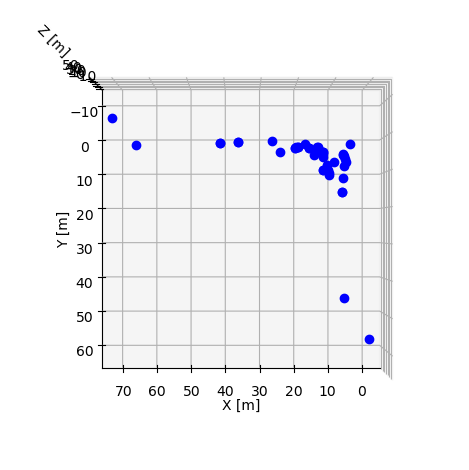

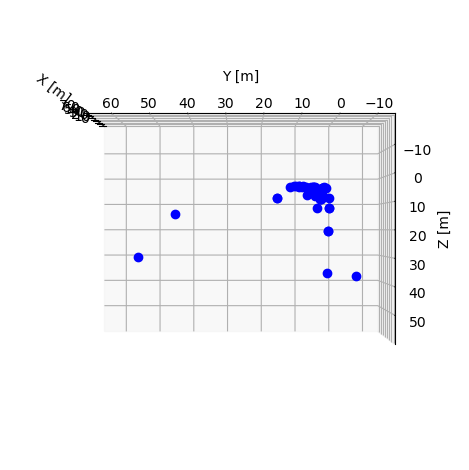

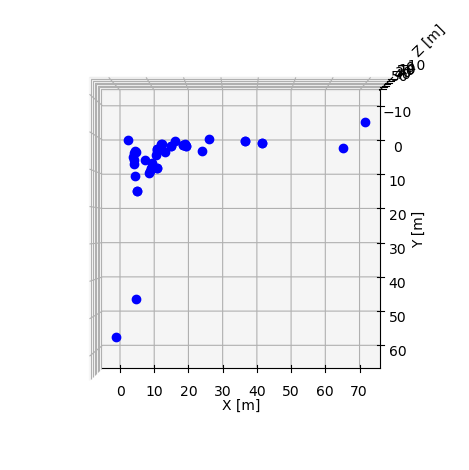

In [5]:
# visualize 3D points
for i in range(0, 360, 90):
    ax = plt.figure(layout='tight').add_subplot(projection='3d')
    ax.plot(X[:,0], X[:,1], X[:,2], 'bo')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.grid(True)
    set_axes_equal(ax)
    ax.view_init(elev=i, azim=i)
    plt.show()